/home/tanglongbin/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Text 1/200
Epoch 1/2 - Loss: 20.7099
Epoch 2/2 - Loss: 20.3344
Text 2/200
Epoch 1/2 - Loss: 20.6076
Epoch 2/2 - Loss: 20.5465
Text 3/200
Epoch 1/2 - Loss: 20.6752
Epoch 2/2 - Loss: 20.5861
Text 4/200
Epoch 1/2 - Loss: 20.1468
Epoch 2/2 - Loss: 18.5839
Text 5/200
Epoch 1/2 - Loss: 20.2906
Epoch 2/2 - Loss: 20.4316
Text 6/200
Epoch 1/2 - Loss: 20.4885
Epoch 2/2 - Loss: 19.5491
Text 7/200
Epoch 1/2 - Loss: 19.6429
Epoch 2/2 - Loss: 19.7617
Text 8/200
Epoch 1/2 - Loss: 20.6716
Epoch 2/2 - Loss: 19.8746
Text 9/200
Epoch 1/2 - Loss: 19.5151
Epoch 2/2 - Loss: 18.7474
Text 10/200
Epoch 1/2 - Loss: 20.1413
Epoch 2/2 - Loss: 19.7698
Text 11/200
Epoch 1/2 - Loss: 19.1181
Epoch 2/2 - Loss: 18.3649
Text 12/200
Epoch 1/2 - Loss: 20.6568
Epoch 2/2 - Loss: 20.0465
Text 13/200
Epoch 1/2 - Loss: 19.1977
Epoch 2/2 - Loss: 18.2869
Text 14/200
Epoch 1/2 - Loss: 19.8253
Epoch 2/2 - Loss: 19.3722
Text 15/200
Epoch 1/2 - Loss: 15.4169
Epoch 2/2 - Loss: 14.9126
Text 16/200
Epoch 1/2 - Loss: 19.8254
Epoch 2/2 -

/home/tanglongbin/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 9463 samples in 3.164s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9463
[t-SNE] Computed conditional probabilities for sample 2000 / 9463
[t-SNE] Computed conditional probabilities for sample 3000 / 9463
[t-SNE] Computed conditional probabilities for sample 4000 / 9463
[t-SNE] Computed conditional probabilities for sample 5000 / 9463
[t-SNE] Computed conditional probabilities for sample 6000 / 9463
[t-SNE] Computed conditional probabilities for sample 7000 / 9463
[t-SNE] Computed conditional probabilities for sample 8000 / 9463
[t-SNE] Computed conditional probabilities for sample 9000 / 9463
[t-SNE] Computed conditional probabilities for sample 9463 / 9463
[t-SNE] Mean sigma: 0.011374


/home/tanglongbin/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.387260
[t-SNE] KL divergence after 1000 iterations: 2.207291


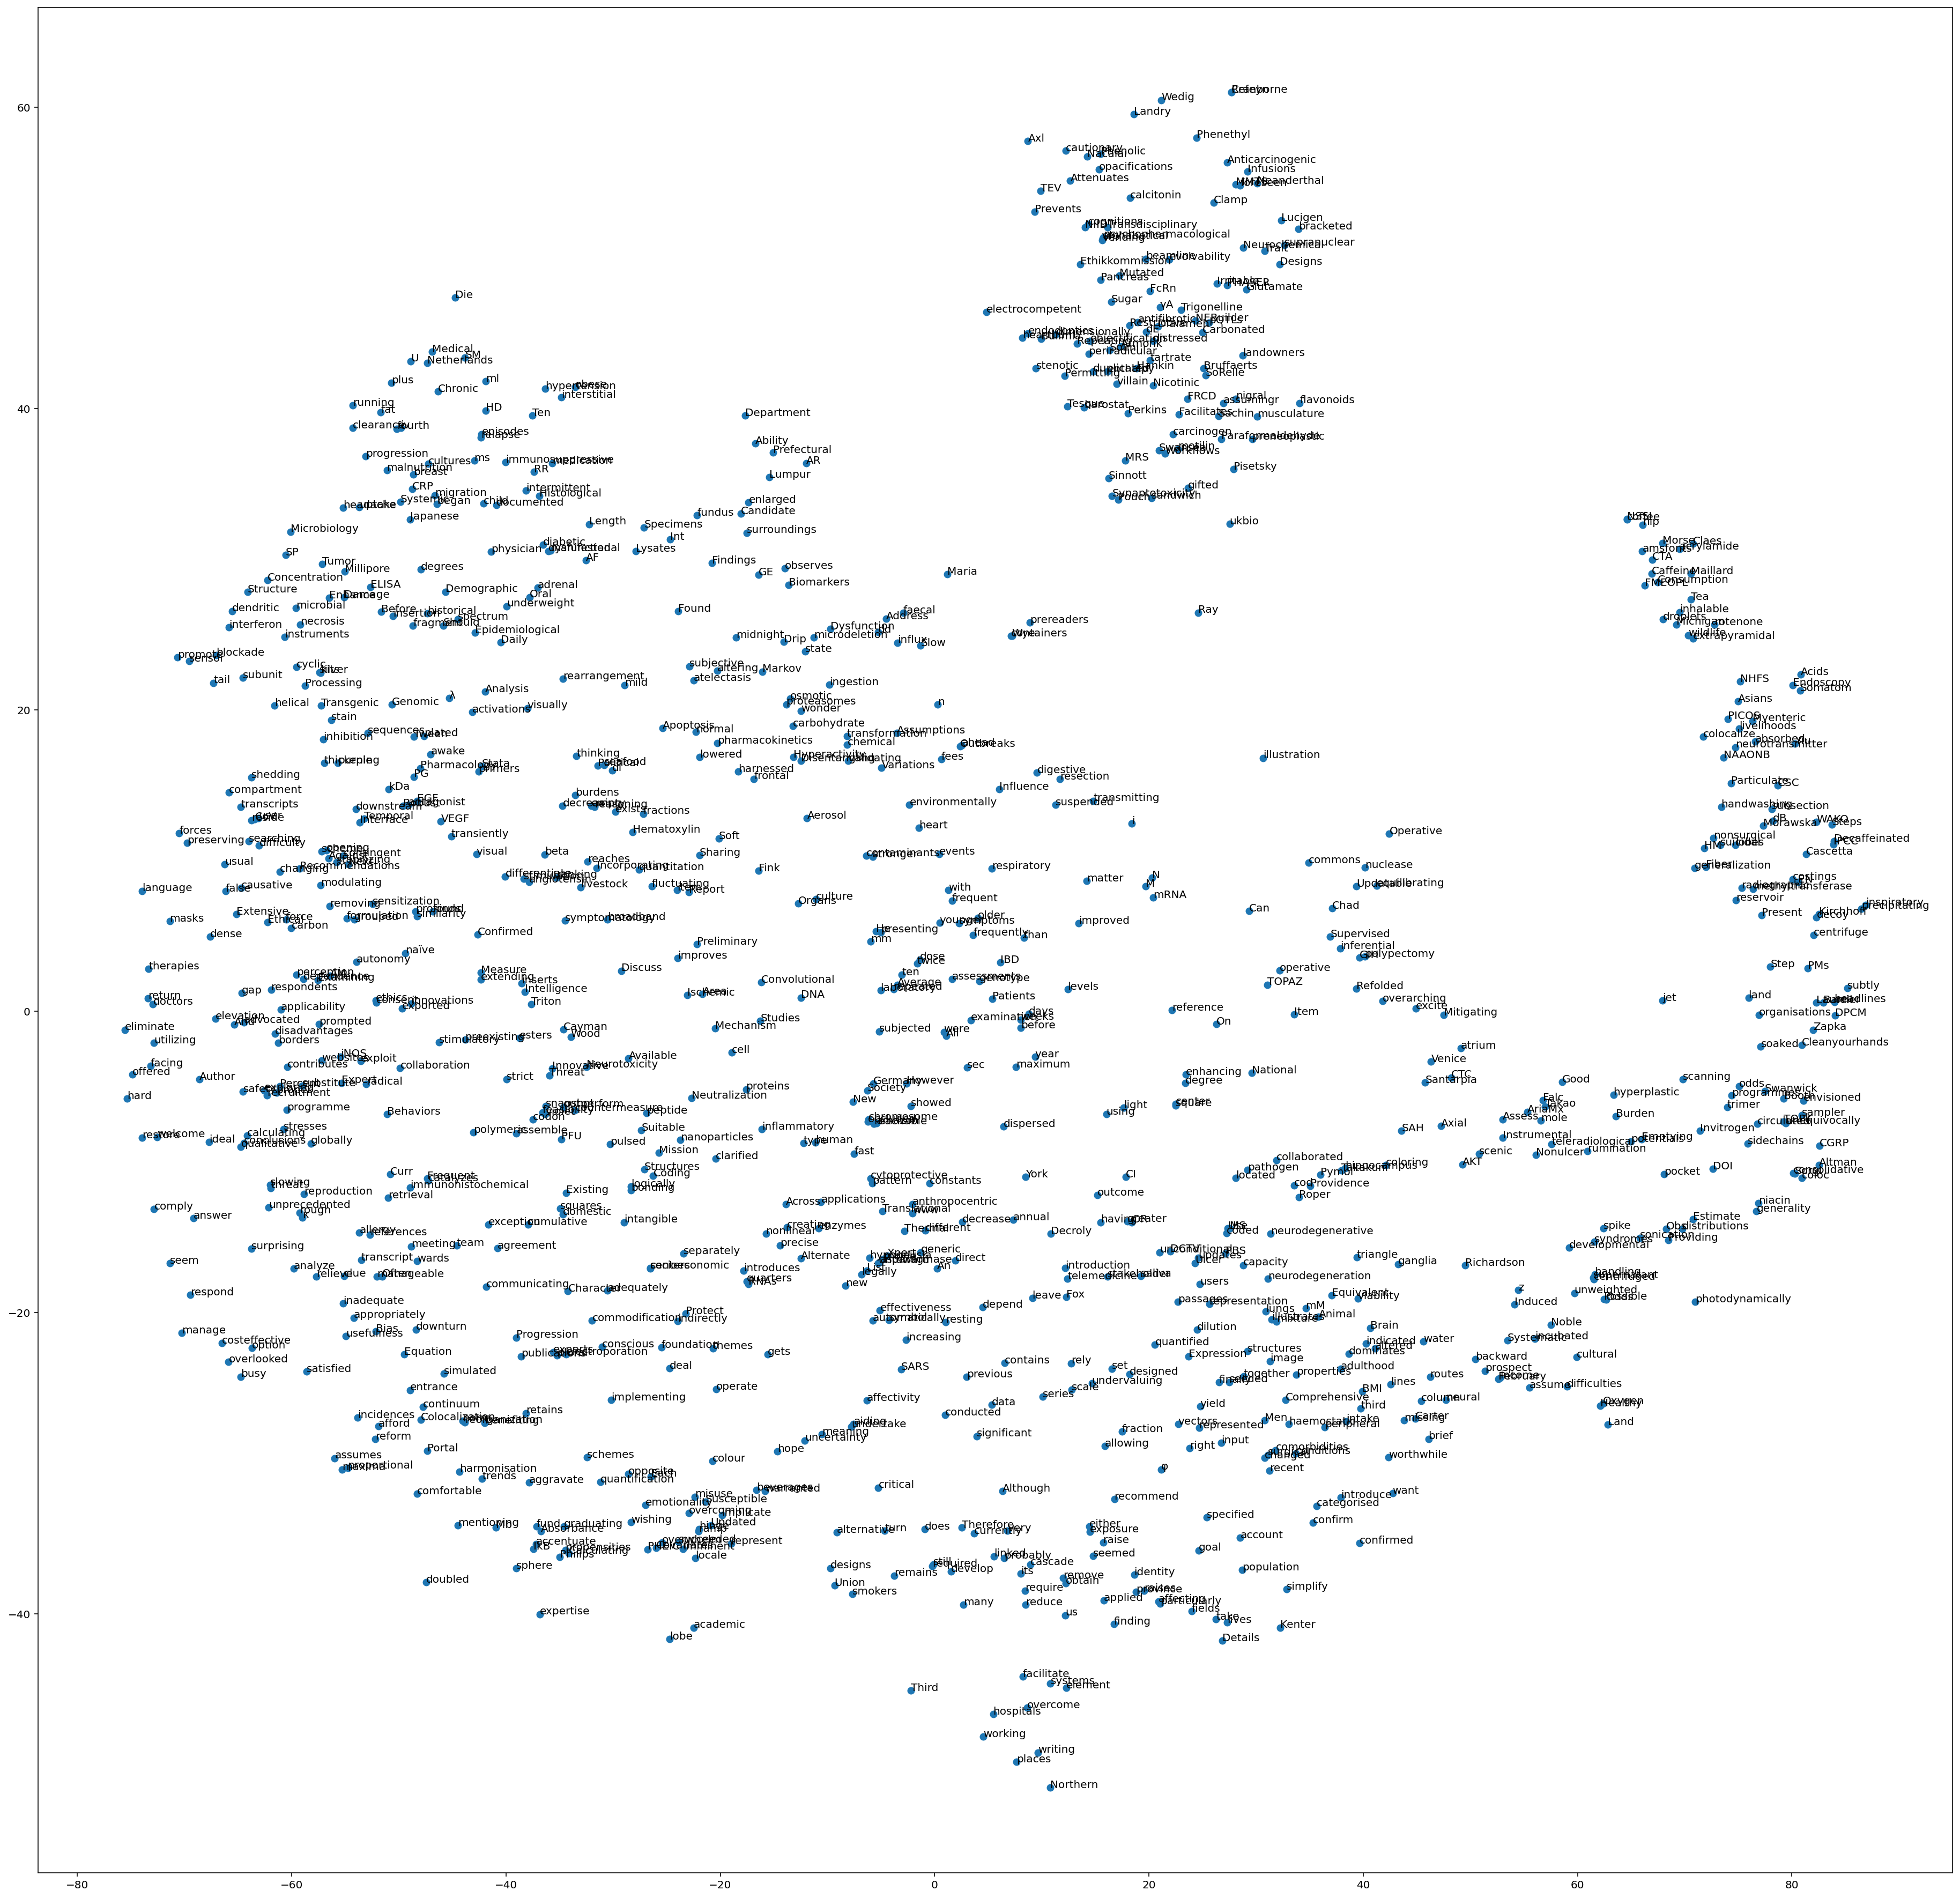

In [1]:
import os
import torch
import random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


# 分词文件夹目录
TokensDirPath = "/home/tanglongbin/NLP/nltk_text"
# 作为词汇表的Tokens文件数量
TokensFileNum = 20
# 词汇量
VocabSize = 10000

# 文章目录（split_text目录）
TextDirPath = "/home/tanglongbin/NLP/split_text"
# 用于训练的文章数量
TextNum = 200
# 每篇文章训练的次数
EpochsNum = 2
# 中心词一侧Positive单词的数量
WindowSize = 5
# Negative单词的数量
NegaNum = 2
# 词向量Feature维度
EmbedSize = 300

# 单次训练使用的数量（可更具内存/显卡负载进行调整）
Batch_Size = 512
# 学习速率（步长）
LearningRate = 0.001



# 获取指定文件夹内的所有文件的绝对路径
# return type: List
def GetFilePath(DirPath):
    
    Res = []
    for FilePath, DirNames, FileNames in os.walk(DirPath):
        for FileName in FileNames:
            str_tmp = os.path.join(FilePath, FileName)
            Res.append(str_tmp)
            
    return Res


# 获取Vocabulary
# 返回设定词汇量的vocab字典
def GetVocab():
    TmpList = []
    TokensFiles = GetFilePath(TokensDirPath)
    for i in range(TokensFileNum):
        with open(TokensFiles[i], 'r') as f:
            S = f.readline()
            # String to List
            L = eval(S)
            TmpList += L
    # 获取频率最高的VocabSize-1个单词，并将剩下的单词归类为'<unk>'
    Vocab = dict(Counter(TmpList).most_common(VocabSize-1))
    Vocab["<unk>"] = len(TmpList) - np.sum(list(Vocab.values()))
    
    return Vocab


# 对Vocab里的单词进行编码和词频处理
def AnalyzeVocab(Vocab):
    # encoder & decoder
    idx_to_word = [word for word in Vocab.keys()] 
    word_to_idx = {word:i for i, word in enumerate(idx_to_word)}
    
    # 词频变换 
    word_counts = np.array([count for count in Vocab.values()], dtype=np.float32)
    word_freqs = word_counts / np.sum(word_counts)
    word_freqs = word_freqs ** (3./4.)
    word_freqs = word_freqs / np.sum(word_freqs)  # 用来做 negative sampling
    
    return word_to_idx, idx_to_word, word_freqs


# 创建Dataset, 并对文章进行编码
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, text, word_to_idx, idx_to_word, word_freqs):
        super(Dataset, self).__init__()
        # 编码文章
        self.text_encoded = [word_to_idx.get(word, word_to_idx["<unk>"]) for word in text]
        self.word_to_idx = word_to_idx 
        self.idx_to_word = idx_to_word
        # 转换为Tensor以便于GPU训练
        self.text_encoded = torch.Tensor(self.text_encoded).long()
        self.word_freqs = torch.Tensor(word_freqs)
        
    def __len__(self):
        return len(self.text_encoded)
    
    def __getitem__(self, idx):
        ''' 这个function返回以下数据用于训练
            - 中心词
            - 这个单词附近的(positive)单词
            - 随机采样的K个单词作为negative sample
        '''
        center_word = self.text_encoded[idx] 
        pos_indices = list(range(idx-WindowSize, idx)) + list(range(idx + 1, idx + WindowSize + 1))
        pos_indices = [i % len(self.text_encoded) for i in pos_indices]
        pos_words = self.text_encoded[pos_indices]
        # replacement=False无放回的取
        neg_words = torch.multinomial(self.word_freqs, (NegaNum + 1) * pos_words.shape[0], replacement=False)
        # Neg_words 与 pos_words 取差集，确保 neg_words 中不包含 pos_words
        neg_words = np.setdiff1d(neg_words.numpy(), pos_words.numpy())
        neg_words = neg_words[:NegaNum * pos_words.shape[0]]
        neg_words = torch.Tensor(neg_words)
    
        return center_word, pos_words, neg_words 


# Skip-Gram Model
class EmbeddingModel(torch.nn.Module):
    def __init__(self, vocab_size, embed_size):
        super(EmbeddingModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        
        # 模型建立 & 初始化
        self.embed = torch.nn.Embedding(vocab_size, embed_size)
        initrange = 0.5 / embed_size
        self.embed.weight.data.uniform_(-initrange, initrange)
        
    def forward(self, input_labels, pos_labels, neg_labels):
        '''
        input_labels: 中心词,         [batch_size]
        pos_labels: 中心词周围词       [batch_size * (WindowSize * 2)]
        neg_labelss: 中心词负采样单词  [batch_size, (WindowSize * 2 * NegaNum)]
        return: loss, 返回loss        [batch_size]
        '''
        
        # 编码
        input_embedding = self.embed(input_labels)
        input_embedding = input_embedding.unsqueeze(dim = 2)
        pos_embedding = self.embed(pos_labels)
        neg_embedding = self.embed(neg_labels)
        

        # torch.bmm()为batch间的矩阵相乘（b,n.m)*(b,m,p)=(b,n,p)
        loss_pos = torch.bmm(pos_embedding, input_embedding).squeeze()
        loss_neg = torch.bmm(neg_embedding, -input_embedding).squeeze()
        
        # loss计算
        loss_pos = loss_pos.sigmoid().log().sum(dim = 1)
        loss_neg = loss_neg.sigmoid().log().sum(dim = 1)
        loss = (loss_pos + loss_neg).mean(dim = 0)
        return -loss
    
    def Embeddings(self):
        return self.embed.weight.data.cpu().numpy()


def  StartTraining():
    
    # 获取Vocab
    Vocab = GetVocab()
    # 获得Vocab分析数据
    word_to_idx, idx_to_word, word_freqs = AnalyzeVocab(Vocab)
    # print(word_to_idx, idx_to_word, word_freqs)
    # return
    # 创建模型(使用Adam算法)
    Model = EmbeddingModel(VocabSize, EmbedSize)
    if torch.cuda.is_available():
        # 若支持cuda加速则使用GPU训练
        Model = Model.cuda()
    Optimizer = torch.optim.Adam(Model.parameters(), lr = LearningRate)
    
    
    
    # 读取Text
    TextFiles = GetFilePath(TextDirPath)
    for i in range(TextNum):
        with open(TextFiles[i]) as f:
            S = f.readline()
            # String to List
            Text = eval(S)
            
            # 创建DataLoader
            dataset = Dataset(Text, word_to_idx, idx_to_word, word_freqs)
            dataloader = torch.utils.data.DataLoader(dataset, batch_size = Batch_Size, shuffle = True, num_workers = 8)
            
            print(f'Text {i+1}/{TextNum}')
            # StartTraining
            for j in range(EpochsNum):
                for k, (input_labels, pos_labels, neg_labels) in enumerate(dataloader):
                    # 转换为 long int 类型
                    input_labels = input_labels.long()
                    pos_labels = pos_labels.long()
                    neg_labels = neg_labels.long()
                    if torch.cuda.is_available(): 
                        # 若支持cuda加速则使用GPU训练
                        input_labels = input_labels.cuda()
                        pos_labels = pos_labels.cuda()
                        neg_labels = neg_labels.cuda()

                    loss = Model(input_labels, pos_labels, neg_labels)
                    Optimizer.zero_grad()
                    loss.backward()
                    Optimizer.step()
        
                print(f'Epoch {j+1}/{EpochsNum} - Loss: {loss.item():.4f}')

    #可视化
    embedding_weights = Model.Embeddings()

    %matplotlib inline
    %config InlineBackend.figure_format = 'retina'
    
    viz_words = 1000
    words = list(Vocab.keys())
    random.shuffle(words)
    ids = [word_to_idx[word] for word in words]
    vector = embedding_weights[ids]
    
    tsne = TSNE(n_components=2,init='pca',verbose=1)
    embed_tsne = tsne.fit_transform(vector)

    plt.figure(figsize=(32,32))
    plt.scatter(embed_tsne[:viz_words,0], embed_tsne[:viz_words,1])

    for i in range(viz_words):
        x = embed_tsne[i][0]
        y = embed_tsne[i][1]
        plt.text(x, y, words[i])
    
    return


def main():
    
    # 开始训练
    StartTraining()
    
    return


if __name__ == '__main__':
    main()